### Approximating the Lorenz attractor with Nonlinear Vector Autoregression (NVAR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings
from IPython.display import clear_output, display
import sympy as sp
import copy

from cmlCore import *
from cmlUtils import *

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
cs = CompatibleStepper(
    dlorenz,
    args=(10,28,8/3,0,0,0),
    callable=RK4,
    dt=0.01
    )
# cs = CompatibleStepper(
#     dlorenz,
#     args=(10,28,8/3,0,0,0),
#     callable=solveIVPCompatibilityFunc('RK45', 0.01),
#     dt=0.01
#     )

In [3]:
T = 300
dt = 0.01

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

# c = 1/50
# feature_mean = lorenz[:,1:].mean(axis=0)
# target_mean = lorenz[1:,1:].mean(axis=0)

raw_data = lorenz[:,1:]
raw_target = lorenz[1:,1:]

data = raw_data
target = raw_target

# data = np.tanh((lorenz[:,1:]-feature_mean)*c)
# target = np.tanh((lorenz[1:,1:]-target_mean)*c)

k=4
# k=8
# k=12
# k=16

train_start=16500
train_end=24000
test_start=train_end
test_end=26000

training_target = target[train_start:train_end]
test_target = target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

train_indices.shape, test_indices.shape

((7500,), (2000,))

In [5]:
model = NVARModel(k=4, s=4, reg=1e-6, nonlinearFunc=quadraticCombination, hybridCallable=cs, natural_dt=0.01) # k=4 -> 94 "units"

### Training task with ODE fit

The standard training task to fit NVAR outputs to training data points with regularization is:

$$
\min_W \big\{\lVert HW - Y \rVert_2^2 + r \lVert W \rVert_2^2\big\}
$$

We can optionally add a fit to the ODE (e.g. model derivatives) and the derivative of the ODE:

$$
\min_W \big\{w_d \lVert HW - Y \rVert_2^2 + w_{m_1} \lVert D_1^T HW - M_1 \rVert_2^2 + w_{m_2} \lVert D_2^T HW - M_2 \rVert_2^2 + r \lVert W \rVert_2^2\big\}
$$

Where $D_1$ is the first-order central difference matrix, $D_2$ is the second-order central difference matrix, $M_1$ is the ODE evaluated at the training outputs, and $M_2$ is the derivative of the ODE evaluated at the training outputs, and $w_d$, $w_{m_1}$, and $w_{m_2}$ are scalar coefficients.

In [58]:
loss_weight_arr = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1],
    # [1,1,0],
    # [1,0,1],
    # [0,1,1],
    [1,1,1]
])
summary_df = pd.DataFrame()
model_arr = []
for x in loss_weight_arr:
    model = NVARModel(k=4, s=4, reg=1e-6, nonlinearFunc=quadraticCombination, hybridCallable=cs, natural_dt=0.01) # k=4 -> 94 "units"
    model.train(
        data,
        target,
        train_indices,
        ODEFunc=simple_dlorenz(),
        D_ODEFunc=simple_ddlorenz(),
        dataLossFactor=x[0],
        ODELossFactor=x[1],
        D_ODELossFactor=x[2],
        printResults=False
        )
    summary_df[np.array2string(x)] = model.training_df['NRMSE']
    model.test(data, target, test_indices, printResults=False)
    model_arr.append(model)
print("NRMSE of training loss components with varying objective coefficients")
print("[data loss, ODE loss, ODE' loss]")
# print(summary_df)
summary_df

NRMSE of training loss components with varying objective coefficients
[data loss, ODE loss, ODE' loss]


,[1 0 0],[0 1 0],[0 0 1],[1 1 1]
Component,,,,
Data,2.271710e-08,5.399965e-04,2.709083e-04,0.000272
ODE,1.415943e-03,3.846767e-07,7.097949e-04,0.000708
ODE',9.224144e-04,9.339914e-04,3.784908e-07,0.000002
Regularization,3.816480e-02,3.809798e-02,3.813836e-02,0.038138
Total,4.050318e-02,3.957235e-02,3.911944e-02,0.039120


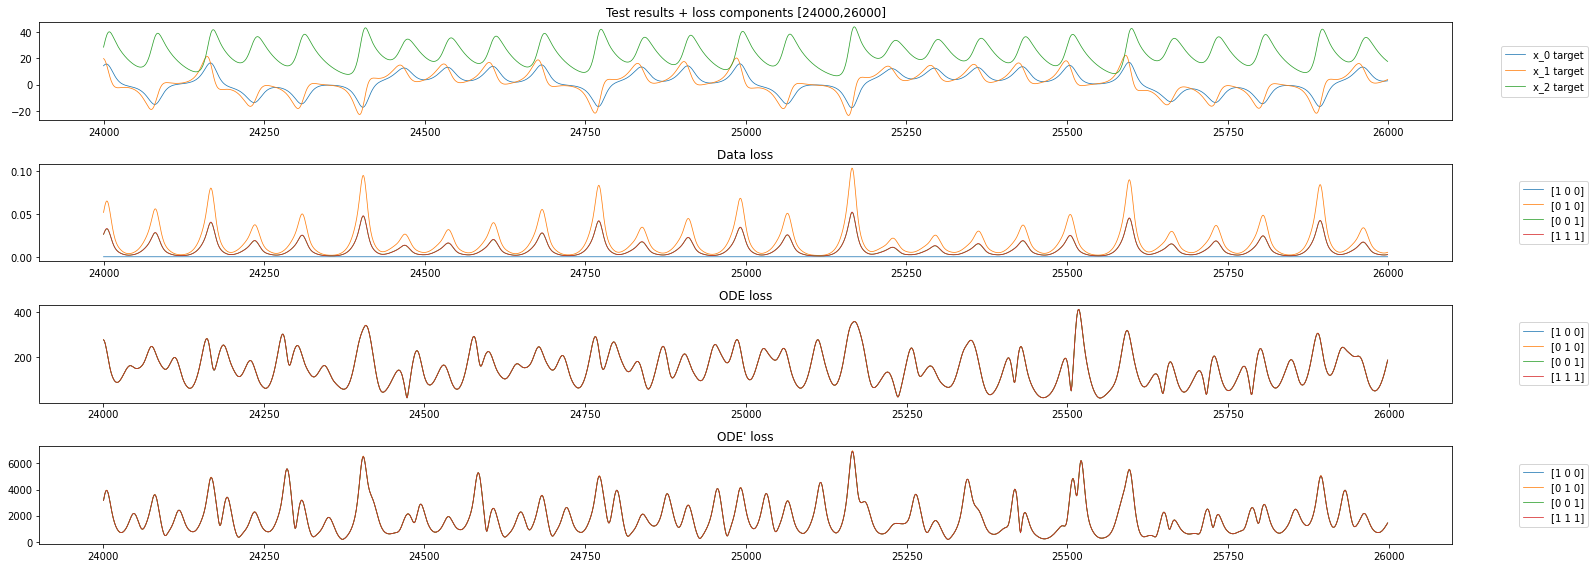

In [59]:
testTarget = target
figsize=(22,8)
t0 = test_start
t_forward = 2000
tf = test_start + t_forward

model_dx = np.array([simple_dlorenz()(x) for x in testTarget[1:-1]])
model_ddxx = np.array([simple_ddlorenz()(x) for x in testTarget[1:-1]])

pred_dx_arr = []
pred_ddxx_arr = []
for model in model_arr:
    D1 = firstCentralDiffMatrix(len(model.test_out), model.natural_dt)
    D2 = secondCentralDiffMatrix(len(model.test_out), model.natural_dt)
    pred_dx = D1.T @ model.test_out
    pred_ddxx = D2.T @ model.test_out
    pred_dx_arr.append(pred_dx)
    pred_ddxx_arr.append(pred_ddxx)

fig, axs = plt.subplots(4, figsize=figsize)
labels = [f'x_{i}' for i in range(testTarget.shape[1])]
for i in range(len(labels)):
    axs[0].plot(np.arange(t0,t0+t_forward), testTarget[t0:t0+t_forward,i], linewidth=0.75, label=f'{labels[i]} target')
for i in range(len(loss_weight_arr)):
    model = model_arr[i]
    pred_dx = pred_dx_arr[i]
    pred_ddxx = pred_ddxx_arr[i]
    axs[1].plot(np.arange(t0,t0+t_forward), [np.linalg.norm(model.test_out[i]-testTarget[t0+i]) for i in range(t_forward)], linewidth=0.75, label=f'{loss_weight_arr[i]}')
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'{loss_weight_arr[i]}')
    axs[3].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_ddxx[i]-model_ddxx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'{loss_weight_arr[i]}')
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[2].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[3].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[0].set_title(f'Test results + loss components [{t0},{t0+t_forward}]')
axs[1].set_title(f'Data loss')
axs[2].set_title(f'ODE loss')
axs[3].set_title(f"ODE' loss")
fig.tight_layout()
plt.show()

[1 1 1]

In [60]:
model111 = model_arr[-1]

valid time : 150
RMSE       : 18.89531226908543
NRMSE      : 0.4729052693817438


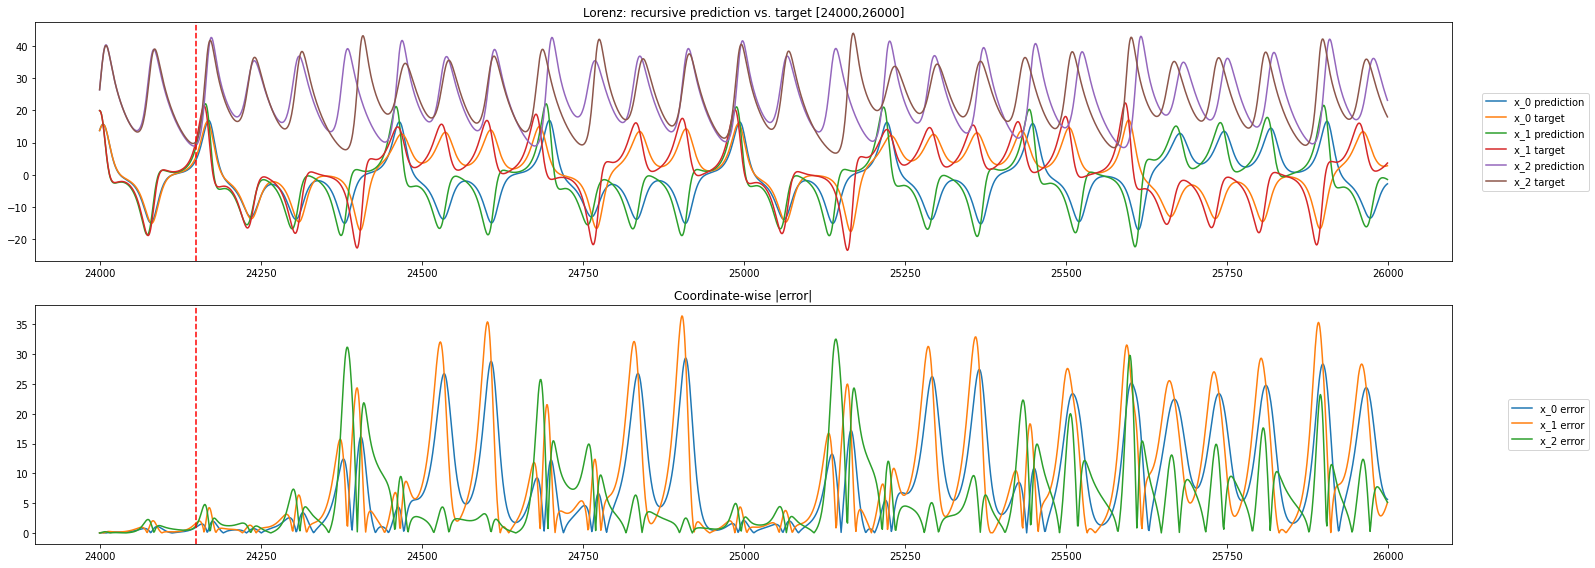

In [61]:
t_forward = 2000
model111_recursive_out = model111.recursive_predict(data, train_start, train_end, t_forward)

vt = validTime(0.2)(model111_recursive_out, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
print(f'RMSE       : {RMSE(model111_recursive_out, target[test_start:test_start+t_forward])}')
print(f'NRMSE      : {NRMSE(model111_recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(model111_recursive_out, data, train_end, t_forward, vline_x=test_start+vt)

In [62]:
model010 = model_arr[1]

valid time : 134
RMSE       : 20.32120465503622
NRMSE      : 0.5085920055036272


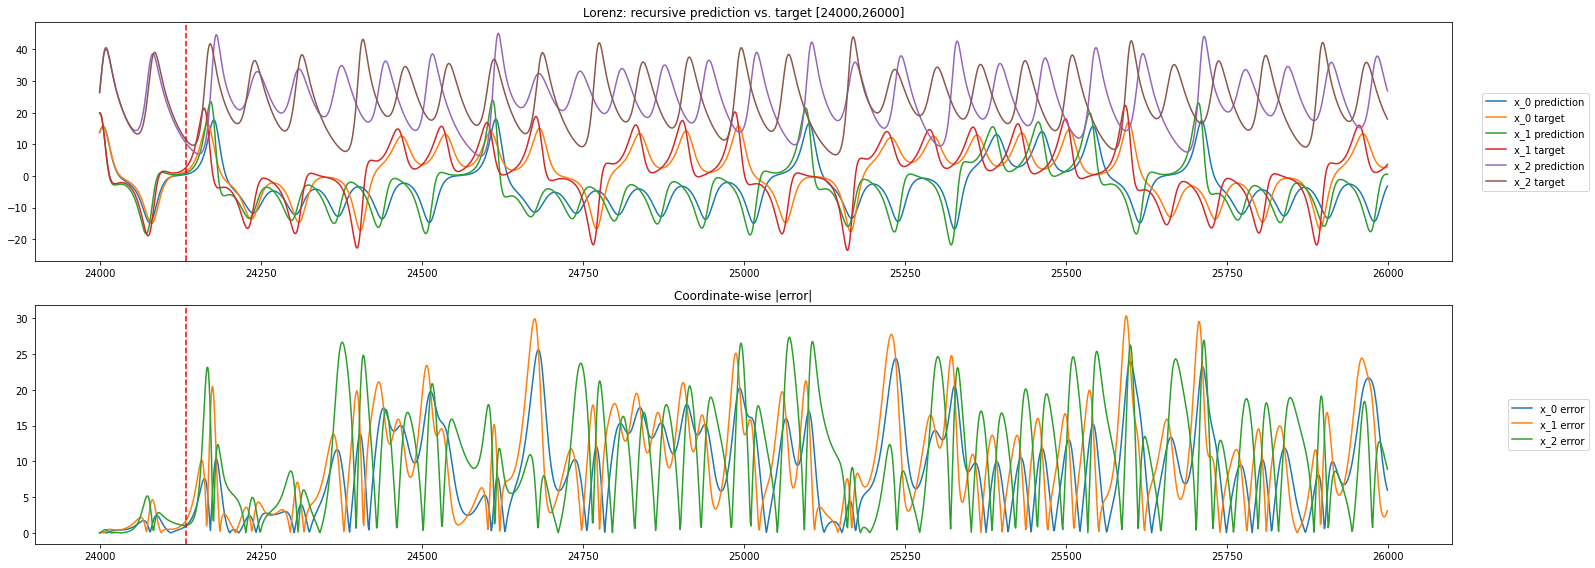

In [63]:
t_forward = 2000
model010_recursive_out = model010.recursive_predict(data, train_start, train_end, t_forward)

vt = validTime(0.2)(model010_recursive_out, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
print(f'RMSE       : {RMSE(model010_recursive_out, target[test_start:test_start+t_forward])}')
print(f'NRMSE      : {NRMSE(model010_recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(model010_recursive_out, data, train_end, t_forward, vline_x=test_start+vt)

In [64]:
model100 = model_arr[0]

valid time : 1565
RMSE       : 6.720406825898166
NRMSE      : 0.16819599248200778


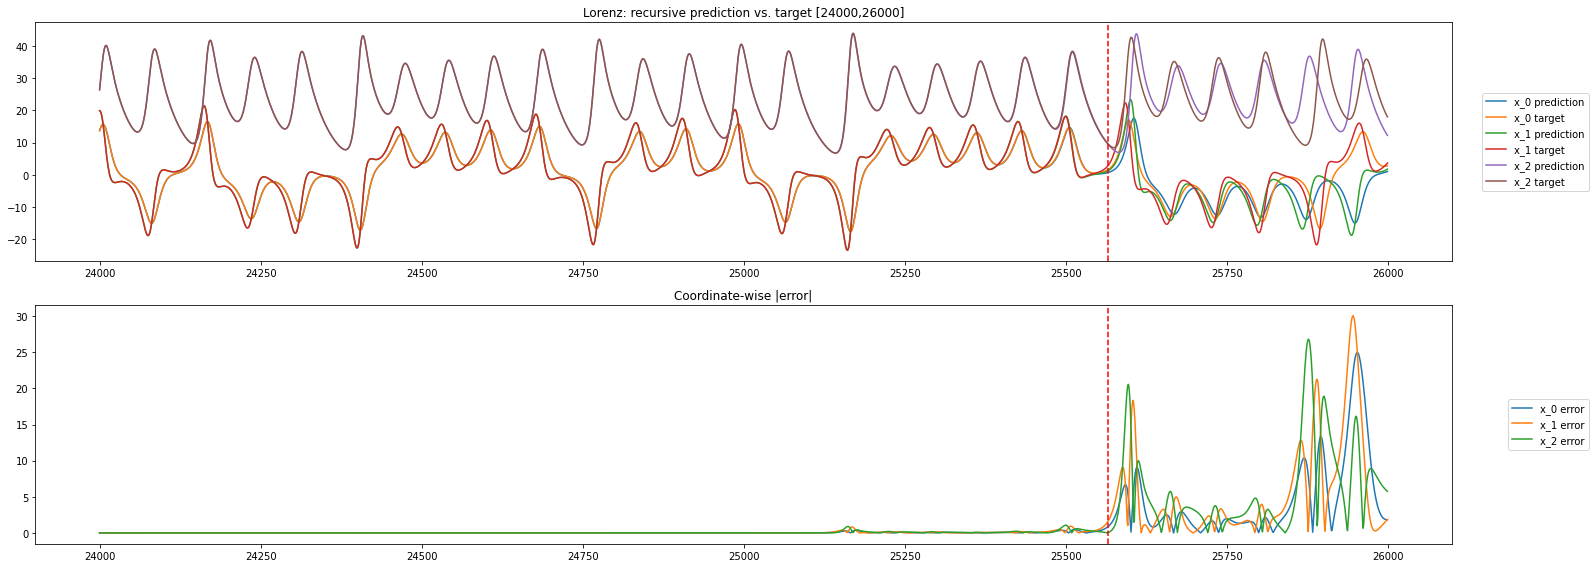

In [65]:
t_forward = 2000
model100_recursive_out = model100.recursive_predict(data, train_start, train_end, t_forward)

vt = validTime(0.2)(model100_recursive_out, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
print(f'RMSE       : {RMSE(model100_recursive_out, target[test_start:test_start+t_forward])}')
print(f'NRMSE      : {NRMSE(model100_recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(model100_recursive_out, data, train_end, t_forward, vline_x=test_start+vt)

Adding ODE and ODE' to the training objective apparently reduces the model's recursive fit/valid time for the training data points. What about the ODE fit in the recursive case?

In [66]:
t_forward = 2000

D1 = firstCentralDiffMatrix(t_forward, dt)
D2 = secondCentralDiffMatrix(t_forward, dt)

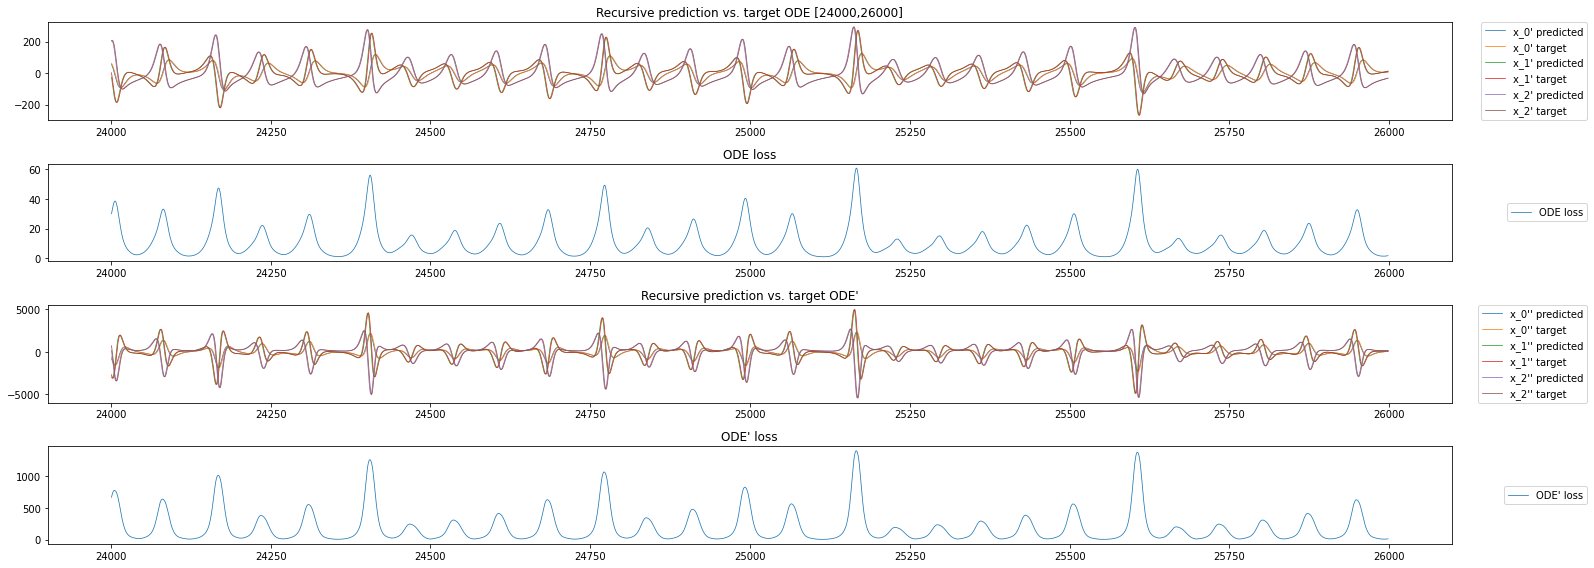

In [67]:
model = model100
recursive_out = model.recursive_predict(data, train_start, train_end, t_forward)

pred_dx = D1.T @ recursive_out
pred_ddxx = D2.T @ recursive_out
model_dx = np.array([simple_dlorenz()(x) for x in recursive_out])
model_ddxx = np.array([simple_ddlorenz()(x) for x in recursive_out])

fig, axs = plt.subplots(4, figsize=figsize)
labels = [f'x_{i}' for i in range(testTarget.shape[1])]
for i in range(len(labels)):
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), pred_dx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}' predicted")
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), model_dx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}' target")
axs[1].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'ODE loss')
for i in range(len(labels)):
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), pred_ddxx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}'' predicted")
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), model_ddxx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}'' target")
axs[3].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_ddxx[i]-model_ddxx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f"ODE' loss")

axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[2].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[3].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[0].set_title(f"Recursive prediction vs. target ODE [{t0},{t0+t_forward}]")
axs[1].set_title(f'ODE loss')
axs[2].set_title(f"Recursive prediction vs. target ODE'")
axs[3].set_title(f"ODE' loss")
fig.tight_layout()
plt.show()

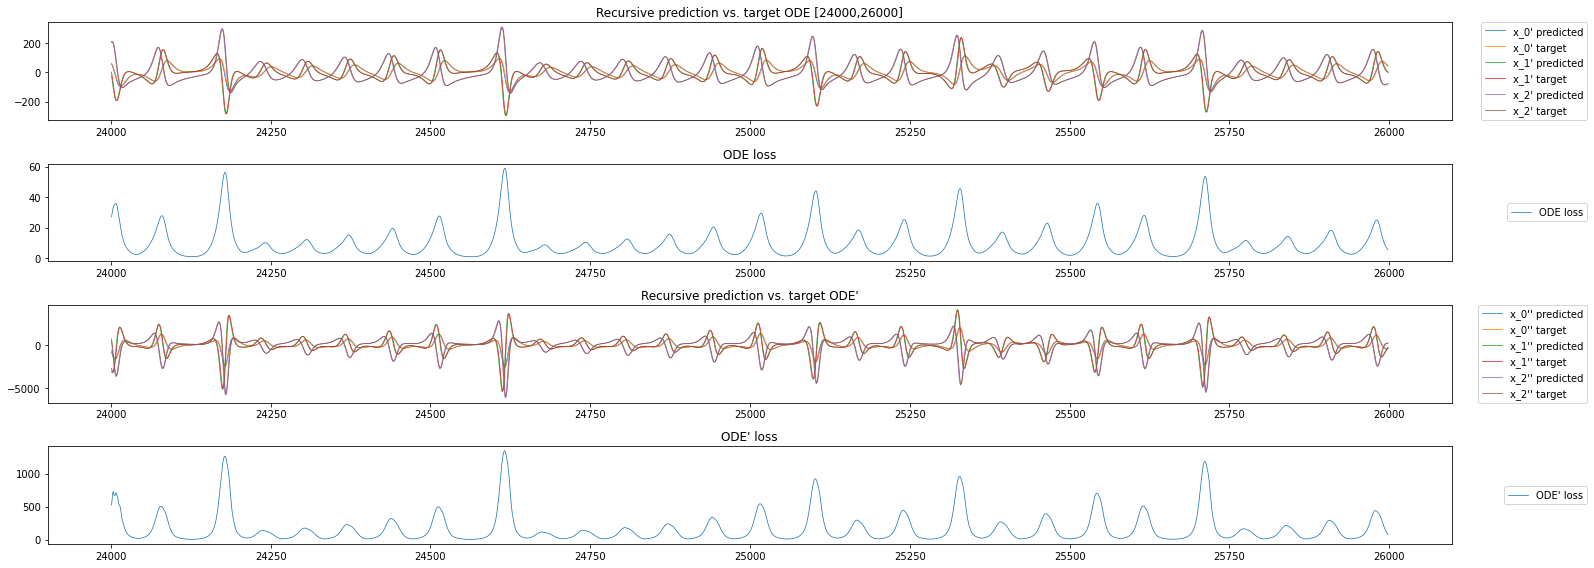

In [68]:
model = model010
recursive_out = model.recursive_predict(data, train_start, train_end, t_forward)

pred_dx = D1.T @ recursive_out
pred_ddxx = D2.T @ recursive_out
model_dx = np.array([simple_dlorenz()(x) for x in recursive_out])
model_ddxx = np.array([simple_ddlorenz()(x) for x in recursive_out])

fig, axs = plt.subplots(4, figsize=figsize)
labels = [f'x_{i}' for i in range(testTarget.shape[1])]
for i in range(len(labels)):
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), pred_dx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}' predicted")
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), model_dx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}' target")
axs[1].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'ODE loss')
for i in range(len(labels)):
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), pred_ddxx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}'' predicted")
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), model_ddxx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}'' target")
axs[3].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_ddxx[i]-model_ddxx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f"ODE' loss")

axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[2].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[3].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[0].set_title(f"Recursive prediction vs. target ODE [{t0},{t0+t_forward}]")
axs[1].set_title(f'ODE loss')
axs[2].set_title(f"Recursive prediction vs. target ODE'")
axs[3].set_title(f"ODE' loss")
fig.tight_layout()
plt.show()

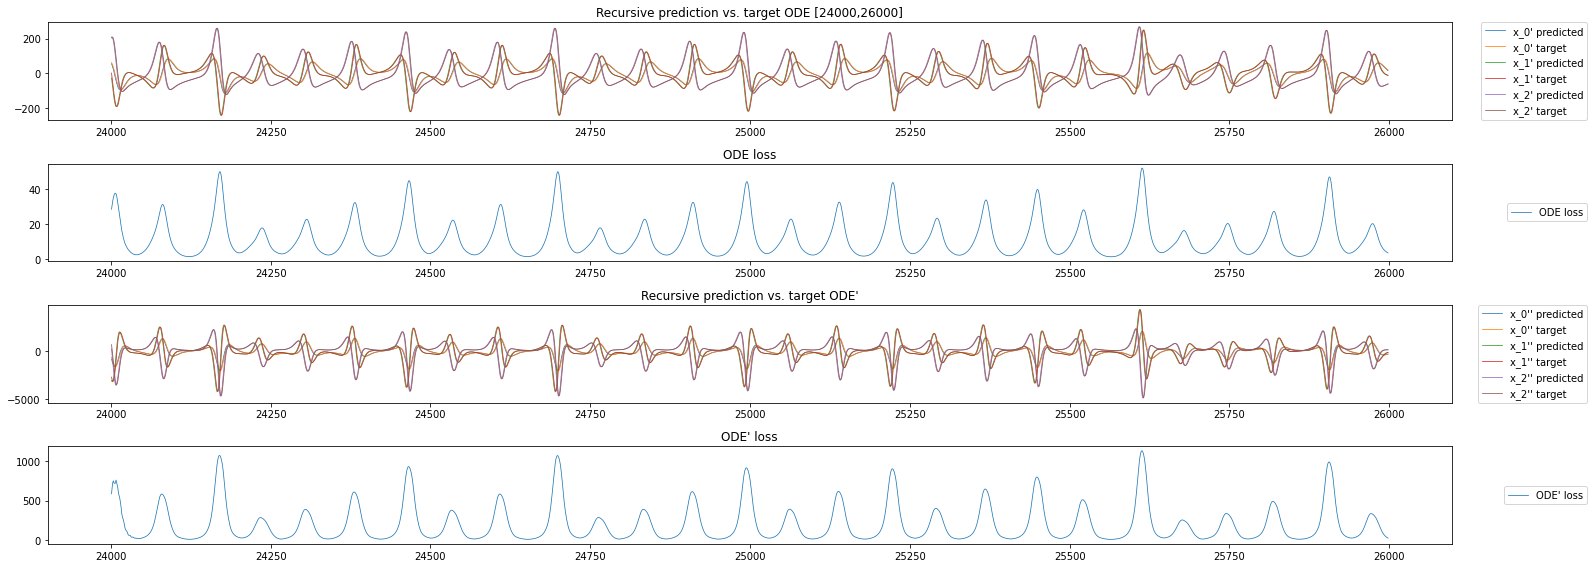

In [69]:
model = model111
recursive_out = model.recursive_predict(data, train_start, train_end, t_forward)

pred_dx = D1.T @ recursive_out
pred_ddxx = D2.T @ recursive_out
model_dx = np.array([simple_dlorenz()(x) for x in recursive_out])
model_ddxx = np.array([simple_ddlorenz()(x) for x in recursive_out])

fig, axs = plt.subplots(4, figsize=figsize)
labels = [f'x_{i}' for i in range(testTarget.shape[1])]
for i in range(len(labels)):
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), pred_dx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}' predicted")
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), model_dx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}' target")
axs[1].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'ODE loss')
for i in range(len(labels)):
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), pred_ddxx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}'' predicted")
    axs[2].plot(np.arange(t0+1,t0+t_forward-1), model_ddxx[:t_forward-2,i], linewidth=0.75, label=f"{labels[i]}'' target")
axs[3].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_ddxx[i]-model_ddxx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f"ODE' loss")

axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[2].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[3].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[0].set_title(f"Recursive prediction vs. target ODE [{t0},{t0+t_forward}]")
axs[1].set_title(f'ODE loss')
axs[2].set_title(f"Recursive prediction vs. target ODE'")
axs[3].set_title(f"ODE' loss")
fig.tight_layout()
plt.show()

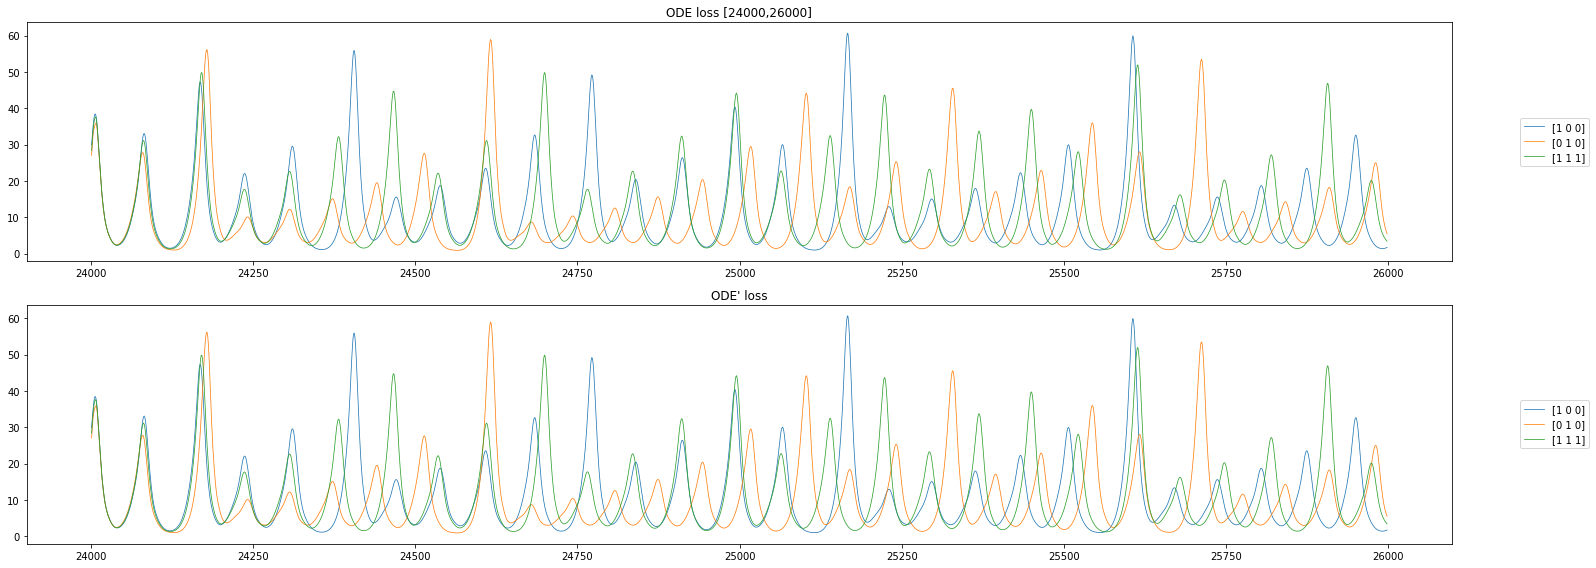

In [71]:
model_arr = [
    model100,
    model010,
    model111,
]

label_arr = np.array([
    [1,0,0],
    [0,1,0],
    [1,1,1],
])

recursive_out_arr = [model.recursive_predict(data, train_start, train_end, t_forward) for model in model_arr]

pred_dx_arr = []
pred_ddxx_arr = []
model_dx_arr = []
model_ddxx_arr = []
for i in range(len(model_arr)):
    model = model_arr[i]
    recursive_out = recursive_out_arr[i]
    pred_dx = D1.T @ recursive_out
    pred_ddxx = D2.T @ recursive_out
    pred_dx_arr.append(pred_dx)
    pred_ddxx_arr.append(pred_ddxx)
    model_dx_arr.append(np.array([simple_dlorenz()(x) for x in recursive_out]))
    model_ddxx_arr.append(np.array([simple_ddlorenz()(x) for x in recursive_out]))

fig, axs = plt.subplots(2, figsize=figsize)
for i in range(len(model_arr)):
    pred_dx = pred_dx_arr[i]
    pred_ddxx = pred_ddxx_arr[i]
    model_dx = model_dx_arr[i]
    model_ddxx = model_ddxx_arr[i]
    axs[0].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'{np.array2string(label_arr[i])}')
    axs[1].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f'{np.array2string(label_arr[i])}')

axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[0].set_title(f"ODE loss [{t0},{t0+t_forward}]")
axs[1].set_title(f"ODE' loss")
fig.tight_layout()
plt.show()

How well does the original "true" data satisfy the ODE anyway?

In [72]:
D1 = firstCentralDiffMatrix(len(data), dt)
D2 = secondCentralDiffMatrix(len(data), dt)

In [75]:
pred_dx = D1.T @ data
pred_ddxx = D2.T @ data
model_dx = np.array([simple_dlorenz()(x) for x in data[1:-1]])
model_ddxx = np.array([simple_ddlorenz()(x) for x in data[1:-1]])

In [78]:
NRMSE(pred_dx, model_dx), NRMSE(pred_ddxx, model_ddxx)

(0.001355729340578026, 0.0008766274977812489)

In [79]:
summary_df

,[1 0 0],[0 1 0],[0 0 1],[1 1 1]
Component,,,,
Data,2.271710e-08,5.399965e-04,2.709083e-04,0.000272
ODE,1.415943e-03,3.846767e-07,7.097949e-04,0.000708
ODE',9.224144e-04,9.339914e-04,3.784908e-07,0.000002
Regularization,3.816480e-02,3.809798e-02,3.813836e-02,0.038138
Total,4.050318e-02,3.957235e-02,3.911944e-02,0.039120


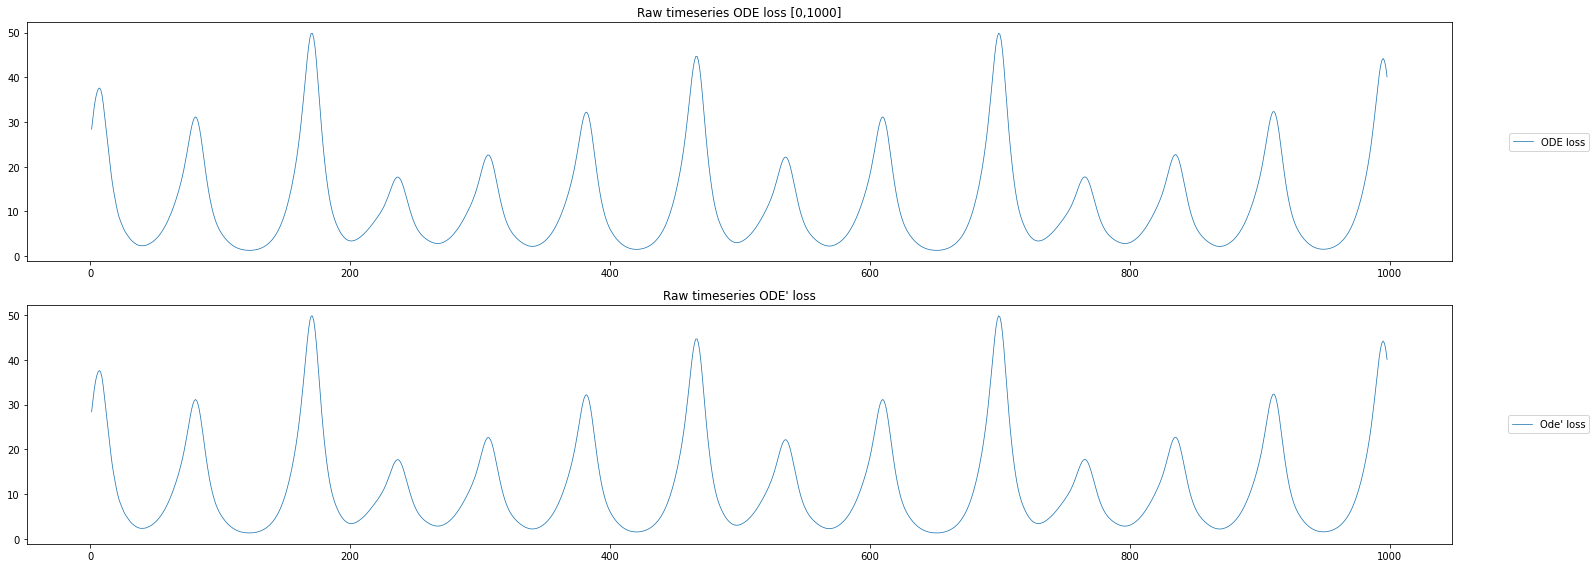

In [81]:
t0 = 0
t_forward = 1000

fig, axs = plt.subplots(2, figsize=figsize)
axs[0].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f"ODE loss")
axs[1].plot(np.arange(t0+1,t0+t_forward-1), [np.linalg.norm(pred_dx[i]-model_dx[i]) for i in range(t_forward-2)], linewidth=0.75, label=f"Ode' loss")

axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[0].set_title(f"Raw timeseries ODE loss [{t0},{t0+t_forward}]")
axs[1].set_title(f"Raw timeseries ODE' loss")
fig.tight_layout()
plt.show()